## Lab6 PyTorch: Модулі та шари

### Що таке модулі?

Модуль — це проміжний рівень абстракції між одним шаром нейронної мережі та повною моделлю.
У PyTorch модулі — це основні будівельні блоки, з яких складаються як окремі шари, так і цілі мережі.
Вони дозволяють гнучко поєднувати, вкладати та повторно використовувати різні компоненти мережі.

---

Якщо потрібно, можу допомогти розписати далі або пояснити конкретні приклади використання модулів у PyTorch.


![Multiple layers are combined into modules, forming repeating patterns of larger models.](./img/blocks.svg)

З програмної точки зору, модуль у PyTorch — це клас. Будь-який його підклас має:

* визначати метод **forward**, який описує, як вхідні дані перетворюються у вихідні (пряме поширення);
* зберігати всі необхідні параметри (ваги, біаси тощо).

Тобто модуль — це об’єкт із власним поведінкою (forward) і станом (параметрами), який можна використовувати як будівельний блок для нейронної мережі.


Start with necessary imports:

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

### Зв’язування модулів

Ми можемо використовувати вбудовану функцію `Sequential`, щоб з’єднувати шари разом. Нижченаведений код створює прихований шар із 256 нейронами та функцією активації ReLU, а також вихідний шар із 10 нейронами:

In [4]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

X = torch.rand(2, 20)
net(X).shape

torch.Size([2, 10])

### Пряме поширення (Forward propagation)

**Важливо**: щоб використати модель, ми передаємо їй вхідні дані (`net(X)` у наведеному вище прикладі). Це виконує метод `forward` моделі разом із деякими фоновими операціями.

`net(X)` — це насправді скорочення для `net.__call__(X)`. `LazyLinear` — це версія `Linear`, яка *визначає* розміри виходу автоматично.


In [5]:
X.shape

torch.Size([2, 20])

### Створення модуля з нуля

У наведеному нижче фрагменті ми створюємо модуль з нуля, що відповідає багатошаровому перцептрону (MLP) з одним прихованим шаром, який містить 256 нейронів, та вихідним шаром розмірності 10. Зверніть увагу, що клас `MLP` нижче наслідує клас, який представляє модуль (`nn.Module`). Ми значною мірою використовуватимемо методи батьківського класу, додаючи лише свій власний конструктор (метод `__init__` у Python) і метод прямого поширення (`forward`).

In [6]:
class MLP(nn.Module):
    def __init__(self):
        # Викликаємо конструктор батьківського класу nn.Module для виконання
        # необхідної ініціалізації
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.out = nn.LazyLinear(10)

    # Визначаємо пряме поширення моделі, тобто як отримати
    # необхідний вихід моделі на основі вхідних даних X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))


Сфокусуймось спочатку на методі прямого поширення (forward propagation). Зверни увагу, що він приймає `X` як вхід, обчислює приховане представлення з застосуванням активаційної функції та видає логіти (вихід до softmax або іншої функції).

У цій реалізації MLP обидва шари (hidden і out) є змінними екземпляра. Чому це логічно? Уяви, що ми створюємо два екземпляри MLP — `net1` і `net2`, і навчаємо їх на різних даних. Очевидно, ми очікуємо, що вони зберігатимуть різні параметри і відповідно представлятимуть **дві різні моделі**, а не спільні шари чи ваги.

Отже, використання змінних екземпляра гарантує, що кожна модель має **власні, незалежні параметри**.

In [7]:
net = MLP()
net(X).shape

torch.Size([2, 10])

**Отже**: модуль може абстрагувати як окремі шари, так і цілі моделі — або будь-що посередині.

### Написання власного `Sequential`

Потрібно реалізувати два ключові методи:

1. Метод для додавання модулів по одному до списку.
2. Метод прямого поширення (forward propagation), який передає вхідні дані через ланцюг модулів у тому самому порядку, в якому вони були додані.

In [9]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

Note `add_module` and `children` funcs.

Now we can use it:

In [10]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

### Виконання коду у методі прямого поширення

Клас `Sequential` спрощує побудову моделей, дозволяючи зібрати нову архітектуру без потреби визначати власний клас.
Однак не всі архітектури є простими ланцюжками шарів.
Коли потрібна більша гнучкість, краще визначати власні блоки (класи).

Наприклад, нам може знадобитися використання елементів керування потоком (як-от `if`, `for`) у методі `forward`.
Також може бути потреба у виконанні довільних математичних операцій, а не лише стандартних шарів нейромереж.

До цього моменту всі операції в мережах працювали або над активаціями, або над параметрами мережі.
Проте іноді може знадобитися використовувати фіксовані значення, які:

* не є результатами попередніх шарів,
* не є параметрами, які оновлюються під час тренування.

Такі значення називаються **постійними параметрами** (*constant parameters*).

Наприклад, припустимо, ми хочемо реалізувати шар, який обчислює таку функцію:

$$
f(\mathbf{x}, \mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}
$$

де:

* $\mathbf{x}$ — вхід,
* $\mathbf{w}$ — параметр (вага, що навчається),
* $c$ — задана стала, яка **не оновлюється** під час оптимізації.

Це можна реалізувати через клас `FixedHiddenMLP`.


In [11]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Випадкові вагові параметри, для яких не обчислюються градієнти,
        # тому вони залишаються сталими під час тренування
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Повторне використання повнозв’язного шару. Це еквівалентно
        # спільному використанню параметрів між двома повнозв’язними шарами
        X = self.linear(X)
        # Керування потоком (циклічна умова)
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

Ось переклад цього тексту українською:

У цій моделі ми реалізували прихований шар, ваги якого (`self.rand_weight`) ініціалізуються випадковим чином під час створення об’єкта і надалі залишаються сталими. Ця вага не є параметром моделі, тому вона ніколи не оновлюється за допомогою зворотного поширення помилки (backpropagation). Мережа передає вихід цього «фіксованого» шару через повнозв’язний шар.

Зверніть увагу, що перед поверненням результату модель виконує незвичайну операцію. Виконується цикл `while`, який перевіряє, чи норма $\ell_1$ (сума абсолютних значень) вектора виходу більша за 1, і поки ця умова виконується, вихідний вектор ділиться на 2. Нарешті, повертається сума елементів у `X`.

На нашу думку, жодна стандартна нейронна мережа не виконує таку операцію. Ця конкретна операція, можливо, не буде корисною у реальних задачах. Нашою метою є лише показати, як можна інтегрувати довільний код у процес обчислень вашої нейронної мережі.


In [12]:
net = FixedHiddenMLP()
net(X)

tensor(0.2549, grad_fn=<SumBackward0>)

Ми можемо поєднувати різні способи складання модулів разом. У наступному прикладі ми вкладемо модулі дещо креативно.

In [13]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(),
                                 nn.LazyLinear(32), nn.ReLU())
        self.linear = nn.LazyLinear(16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)

tensor(0.2163, grad_fn=<SumBackward0>)

### Параметри

Після того, як ми вибрали архітектуру
і налаштували гіперпараметри,
ми переходимо до циклу навчання,
де наша мета — знайти значення параметрів,
які мінімізують функцію втрат.
Після навчання нам знадобляться ці параметри,
щоб робити прогнози в майбутньому.
Також іноді ми хочемо
витягти параметри,
можливо, щоб повторно використати їх в іншому контексті,
зберегти модель на диск, щоб
запустити її в іншому програмному забезпеченні,
або проаналізувати їх,
щоб отримати наукове розуміння.

Зазвичай ми можемо
ігнорувати дрібні деталі
оголошення та маніпуляції параметрами,
покладаючись на фреймворки глибокого навчання,
які роблять основну роботу.
Проте, коли ми відійдемо від
простих послідовних архітектур зі стандартними шарами,
іноді доведеться заглибитися в
оголошення та маніпуляції параметрами.
У цьому розділі ми розглянемо:

* Доступ до параметрів для налагодження, діагностики та візуалізації.
* Спільне використання параметрів між різними компонентами моделі.

Візьмемо, наприклад, MLP з одним прихованим шаром:

In [14]:
net = nn.Sequential(nn.LazyLinear(8),
                    nn.ReLU(),
                    nn.LazyLinear(1))

X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

In [15]:
X

tensor([[0.1979, 0.2029, 0.1851, 0.5028],
        [0.4797, 0.5983, 0.3032, 0.9344]])

Як ми отримуємо доступ до параметрів кожного шару? За допомогою індексації.

In [16]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2815,  0.1976,  0.0715, -0.2519],
                      [-0.2177,  0.2184,  0.0602, -0.0451],
                      [-0.1265,  0.2998, -0.3104, -0.2772],
                      [-0.1027, -0.2258,  0.1394, -0.1953],
                      [-0.0600,  0.4202,  0.3387, -0.0350],
                      [-0.4331, -0.4423, -0.4857, -0.4939],
                      [ 0.0347,  0.0272, -0.4824, -0.1348],
                      [-0.0579, -0.3795, -0.4692,  0.3741]])),
             ('bias',
              tensor([ 0.3753, -0.1778, -0.2986,  0.0924, -0.1007, -0.3006, -0.0192, -0.1997]))])

In [17]:
net[1].state_dict()

OrderedDict()

Зверніть увагу, що параметри (ваги/зміщення) є екземплярами класу `torch.nn.parameter.Parameter`.

In [18]:
net[2].weight

Parameter containing:
tensor([[ 0.0635,  0.0794, -0.2659,  0.1833,  0.2203,  0.2912, -0.1707,  0.0504]],
       requires_grad=True)

We can use `data` field in order to extract actual data:

In [19]:
net[2].weight.data

tensor([[ 0.0635,  0.0794, -0.2659,  0.1833,  0.2203,  0.2912, -0.1707,  0.0504]])

In [20]:
net[2].weight.shape

torch.Size([1, 8])

In [21]:
net[0].weight.shape

torch.Size([8, 4])

We can also access gradients for each layer:

In [22]:
net[2].weight.grad == None

True

We can also access parameters all at once via `nn.Module.named_parameters()`:

In [23]:
[(name, param.shape) for name, param in net.named_parameters()]

[('0.weight', torch.Size([8, 4])),
 ('0.bias', torch.Size([8])),
 ('2.weight', torch.Size([1, 8])),
 ('2.bias', torch.Size([1]))]

Ми також можемо пов’язувати або ділитися параметрами між різними шарами.

У наведеному нижче прикладі ми створюємо повнозв’язний шар,
а потім використовуємо його параметри спеціально,
щоб задати параметри іншого шару.
Тут нам потрібно спочатку виконати прямий прохід (forward propagation)
`net(X)`, перш ніж отримувати доступ до параметрів.

In [24]:
# We need to give the shared layer a name so that we can refer to its
# parameters
shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


У цьому прикладі показано, що параметри другого і третього шару зв’язані (пов’язані) між собою.
Вони не просто рівні — вони представлені одним і тим самим тензором.
Отже, якщо ми змінюємо один з параметрів,
інший також змінюється.

Можна запитати:
що відбувається з градієнтами, коли параметри пов’язані?
Оскільки параметри моделі містять градієнти,
градієнти другого і третього шару додаються разом
під час зворотного поширення (backpropagation).


### Ініціалізація

За замовчуванням PyTorch ініціалізує матриці вагів та зсувів (bias) рівномірно, вибираючи значення з діапазону, який обчислюється залежно від розмірності входу та виходу. Модуль `nn.init` у PyTorch надає різні готові методи ініціалізації.

Почнемо зі створення прикладної нейронної мережі за допомогою `nn.Sequential`.


In [25]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

torch.Size([2, 1])

### Вбудовані ініціалізатори

Цей код ініціалізує ваги як випадкові змінні за нормальним (гаусовим) розподілом, а зсуви (bias) будуть рівні 0. Метод `apply` рекурсивно застосовує задану функцію до кожного підмодуля:

In [26]:
def init_normal(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=0.01)
        nn.init.zeros_(module.bias)

net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0048,  0.0183, -0.0045,  0.0047]), tensor(0.))

Or we can use constants:

In [27]:
def init_constant(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 1)
        nn.init.zeros_(module.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

We can use indexing to initialize parameters for each layer separately:

In [28]:
def init_xavier(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

def init_42(module):
    if type(module) == nn.Linear:
        nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.6308,  0.3981,  0.0355,  0.2596])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


Іноді потрібні методи ініціалізації
відсутні у фреймворку глибинного навчання.
У наведеному нижче прикладі ми визначаємо ініціалізатор
для будь-якого параметра ваги $w$, використовуючи наступний незвичайний розподіл (тут $U$ позначає рівномірний розподіл):

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \textrm{ with probability } \frac{1}{4} \\
            0    & \textrm{ with probability } \frac{1}{2} \\
        U(-10, -5) & \textrm{ with probability } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


In [29]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000,  8.5447, -8.3079,  9.4334],
        [-0.0000, -6.4583, -0.0000, -5.4168]], grad_fn=<SliceBackward0>)

And, of course, we can always set the parameters directly:

In [30]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  9.5447, -7.3079, 10.4334])

Or in model class constructor:

In [31]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)



### Лінива ініціалізація

PyTorch може відкласти ініціалізацію параметрів, чекаючи першого проходу даних через модель, щоб динамічно визначити розміри кожного шару.

Згодом, при роботі з згортковими нейронними мережами, цей підхід стане ще зручнішим, оскільки розмірність вхідних даних (наприклад, роздільна здатність зображення) впливає на розмірність кожного наступного шару.

Давайте знову створимо персептрон:


In [32]:
net = nn.Sequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

Check first layer params:

In [33]:
net[0].weight

<UninitializedParameter>

We can pass some data:

In [34]:
X = torch.rand(2, 20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

### Custom layers

Let's first try a layer without parameters:

In [35]:
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Let's see if it works:

In [36]:
layer = CenteredLayer()
layer(torch.tensor([1.0, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

We can use it in some models now:

In [37]:
net = nn.Sequential(nn.LazyLinear(128), CenteredLayer())

Check how it works:

In [38]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(5.5879e-09, grad_fn=<MeanBackward0>)

The very small number instead of 0 is due to floating point number arithmetic.

Let's now create a custom layer with parameters: `in_units` and `out_units` for inputs and outputs counts.

In [39]:
class MyLinear(nn.Module):
    def __init__(self, in_units, out_units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, out_units))
        self.bias = nn.Parameter(torch.randn(out_units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

We can instantiate it and check parameters:

In [40]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 1.3170, -0.8199,  0.0033],
        [-1.5403, -1.3372, -0.7153],
        [-0.4825, -1.8492, -0.0956],
        [-0.2137, -0.0974,  0.4601],
        [ 1.2898, -1.1746, -0.5523]], requires_grad=True)

Now invoke forward propagation using our custom layer:

In [41]:
linear(torch.rand(2, 5))

tensor([[1.4625, 0.0000, 0.0109],
        [2.1471, 0.0000, 0.1843]])

Now we can construct a model using the custom layer:

In [42]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[0.1307],
        [3.3386]])

### Loading and saving

Save a single tensor:

In [43]:
x = torch.arange(4)
torch.save(x, 'torch.data')
x

tensor([0, 1, 2, 3])

Now read it back:

In [44]:
x2 = torch.load('torch.data')
x2

tensor([0, 1, 2, 3])

Same can be done with lists of tensors:

In [45]:
y = torch.zeros(4)
torch.save([x, y],'torch2.data')
x2, y2 = torch.load('torch2.data')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Saving dictionaries of tensors also works:

In [46]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'torch_dict.data')
mydict2 = torch.load('torch_dict.data')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

How does this work for complete models? Let's check it, using the example model for multi-layer perceptron.

In [47]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.LazyLinear(256)
        self.output = nn.LazyLinear(10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

We can save the parameters of that model with:

In [48]:
torch.save(net.state_dict(), 'mlp.params')

In order to load the model, we can do this:

In [49]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

Let's verify that original model and cloned model produce same results:

In [50]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

## Крок за кроком з датасетом TorchVision

### Завантаження даних

Давайте завантажимо приклад датасету:

In [51]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch пропонує спеціалізовані бібліотеки для різних доменів, такі як TorchText, TorchVision і TorchAudio, кожна з яких містить власні датасети. Для цього навчального матеріалу ми будемо використовувати датасет з TorchVision.

Модуль `torchvision.datasets` містить об’єкти Dataset для багатьох реальних наборів даних у сфері комп’ютерного зору, таких як CIFAR, COCO (повний список тут). Ми використаємо датасет FashionMNIST. Кожен датасет TorchVision включає два параметри: `transform` і `target_transform`, які відповідно дозволяють змінювати зразки (вхідні дані) і мітки (лейбли).

In [52]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Ми передаємо `Dataset` як аргумент у `DataLoader`. Це створює ітератор для нашого датасету та підтримує автоматичне формування батчів, вибірку, перемішування даних і багатопроцесове завантаження. Тут ми задаємо розмір батчу рівним 64, тобто кожен елемент ітератора `DataLoader` буде повертати батч з 64 прикладів та їхніх міток.

In [53]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Let's visualize some samples:

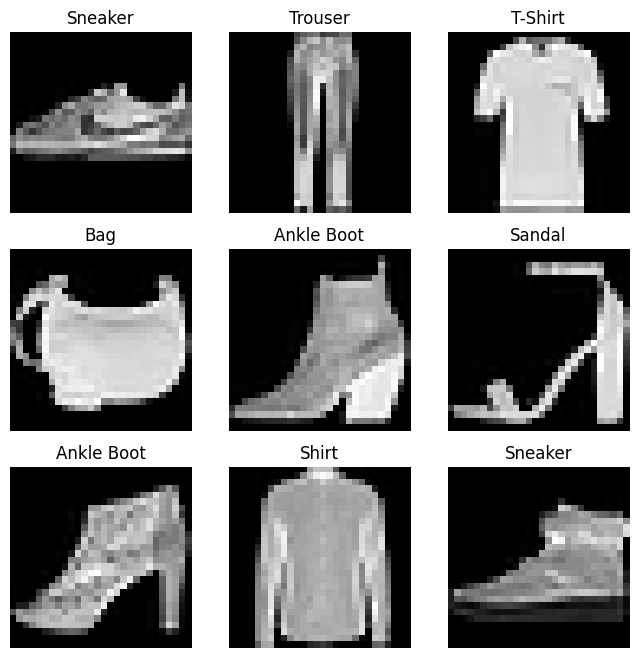

In [54]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Трансформації

Усі датасети TorchVision мають два параметри — `transform` для зміни (преобразування) ознак (features) та `target_transform` для зміни міток (labels). Ці параметри приймають callable-об’єкти з логікою трансформації. Модуль `torchvision.transforms` пропонує кілька часто використовуваних трансформацій "з коробки".

Особливості датасету FashionMNIST представлені у форматі PIL Image, а мітки — у вигляді цілих чисел. Для тренування нам потрібні ознаки у вигляді нормалізованих тензорів, а мітки — у вигляді one-hot кодування. Для цього можна використати трансформації `ToTensor` та `Lambda`.

`target_transform` визначає функцію, яка перетворює ціле число у one-hot закодований тензор. Спочатку створюється тензор нулів розміром 10 (кількість класів у нашому датасеті), після чого метод `scatter_` встановлює значення 1 у позиції, що відповідає мітці `y`.


In [55]:
%matplotlib inline

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Defining a network model

Now that we have the test data, define a neural network with 2 hidden layers and ReLU activation functions:

In [56]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Розберемо кроки:

* Ініціалізуємо шар `nn.Flatten`, який перетворює кожне 2D-зображення розміром 28×28 у безперервний масив з 784 пікселів (розмірність мінібачу на вимірі 0 зберігається).
* `nn.Linear` — це модуль, який застосовує лінійне перетворення до вхідних даних, використовуючи збережені ваги та зсуви (біаси).
* Після лінійних перетворень застосовуються активації `nn.ReLU` для введення нелінійності.
* `nn.Sequential` впорядковує ці модулі у послідовність.

In order to train a model, we also need to specify a loss function and optimizer:

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Цикл навчання

Підсумовуючи, щоб навчити модель, нам потрібно:

* Даталоадер (dataloader), який працює з певним датасетом
* Сама модель (що наслідує від PyTorch `nn.Module`)
* Функція втрат (loss function)
* Оптимізатор

Необхідні кроки:

* Виконати пряме поширення (forward propagation)
* Обчислити втрати (loss)
* Обчислити зворотне поширення (backward propagation)
* Виконати крок градієнтного спуску (gradient descent step)


![A picture](./img/training_loop.png)

In [58]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # This just sets the model in train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We'll also need a test function in order to verify how our model works. Note that we use `torch.no_grad()` as we don't need the gradients when testing:

In [59]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

![A picture](./img/testing_loop.png)

Let's run it:

In [60]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306712  [    0/60000]
loss: 2.295703  [ 6400/60000]
loss: 2.275131  [12800/60000]
loss: 2.268782  [19200/60000]
loss: 2.256227  [25600/60000]
loss: 2.229398  [32000/60000]
loss: 2.229410  [38400/60000]
loss: 2.206944  [44800/60000]
loss: 2.204351  [51200/60000]
loss: 2.155592  [57600/60000]
Test Error: 
 Accuracy: 44.2%, Avg loss: 2.163995 

Epoch 2
-------------------------------
loss: 2.180823  [    0/60000]
loss: 2.170381  [ 6400/60000]
loss: 2.118865  [12800/60000]
loss: 2.125417  [19200/60000]
loss: 2.082753  [25600/60000]
loss: 2.026567  [32000/60000]
loss: 2.042306  [38400/60000]
loss: 1.979805  [44800/60000]
loss: 1.974397  [51200/60000]
loss: 1.886912  [57600/60000]
Test Error: 
 Accuracy: 52.0%, Avg loss: 1.904422 

Epoch 3
-------------------------------
loss: 1.944552  [    0/60000]
loss: 1.914572  [ 6400/60000]
loss: 1.806947  [12800/60000]
loss: 1.827990  [19200/60000]
loss: 1.731864  [25600/60000]
loss: 1.687020  [32000/600

Save and load model:

In [61]:
torch.save(model.state_dict(), "model.pth")
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Let's use the model to make predictions:

In [62]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Switch model to evaluation mode
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
